In [158]:
'''
Business understanding by CRISP-DM continued - 

3. A few key factors affect the price of rental places in Seattle. We use machine learning model specifically XGBoost regressor 
to look into most important features affecting the price.

This notebook involves a big chunk of data cleaning, data preparations and ML modeling along with results visulaization
'''

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from IPython.display import Image

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import train_test_split # for splitting into training,testing
from sklearn.metrics import r2_score, mean_squared_error # for getting the metrics between predictions & test values

In [159]:
# Data gathering
dfs1 = pd.read_csv('C:/Users/vinym/Documents/Py_ML_Deep/Udacity_NanodegreeCourse/Project1/Seattle_AirBnB_Kaggle/calendar.csv')
dfs2 = pd.read_csv('C:/Users/vinym/Documents/Py_ML_Deep/Udacity_NanodegreeCourse/Project1/Seattle_AirBnB_Kaggle/listings.csv')
dfs3 = pd.read_csv('C:/Users/vinym/Documents/Py_ML_Deep/Udacity_NanodegreeCourse/Project1/Seattle_AirBnB_Kaggle/reviews.csv')

In [160]:
# A first look into all the data available in 3 csv files
dfs1.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [161]:
dfs1 = dfs1.dropna(axis = 0, subset = ['price'], how = 'any')

In [162]:
dfs1.shape

(934542, 4)

In [163]:
# Columns having 0 non-null values are dropped. They do affect the data and can skew ML models. 
#Dropping these columns are best as they dont have any values to impute with mean or mode values
dfs2_corr = dfs2.drop(['square_feet', 'license'], axis=1)
dfs2_corr = dfs2_corr.rename(index=str, columns={"id": "listing_id"})

In [164]:
# Finding the object columns
obj_dfs2_corr = dfs2.select_dtypes(include = ['object']).copy()
obj_dfs2_corr.shape
obj_dfs2_corr.columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_s

number of columns with Nan values: 43


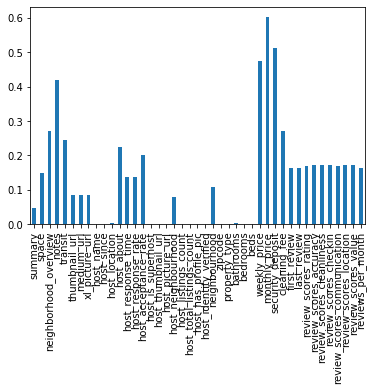

In [165]:
# Data assessment - visually assessing the proportion of missing values in each column
missing_l_df = dfs2_corr.isnull().mean()
missing_l_cols_nan = missing_l_df[missing_l_df>0]
missing_l_cols_nan.plot.bar()
print('number of columns with Nan values:',len(missing_l_cols_nan))
# Output - juridiction_names column can be removed as it is empty

In [166]:
# Data assessments - Unique listings in Boston
total_listings = dfs2_corr['listing_id'].count()
total_hosts = len(dfs2_corr['host_id'].unique())
print('The total unique number of hosts and the number of unique listing are:',total_hosts,',',total_listings)

The total unique number of hosts and the number of unique listing are: 2751 , 3818


In [168]:
#Merge listing and calendar data - Data gathering
dfs = pd.merge(dfs1, dfs2_corr, on = 'listing_id')
#print(len(dfs))
#dfs.columns
dfs.shape

(934542, 93)

In [169]:
# Data cleaning - get rid of the URLs and other useless columns
unneeded_cols1 = ['listing_url','last_scraped','scrape_id','neighbourhood','neighbourhood_cleansed','neighborhood_overview',
                  'notes','transit','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_name',
                  'host_about','host_thumbnail_url','host_picture_url','market','smart_location','country_code','country',
                  'is_location_exact','calendar_last_scraped','first_review','last_review','requires_license', 
                  'jurisdiction_names','price_y','available','description','space','summary','host_neighbourhood',
                  'host_total_listings_count','host_has_profile_pic','neighbourhood_group_cleansed',
                  'host_location', 'host_response_time', 'city', 'state','experiences_offered', 'has_availability', 
                  'calendar_updated','name', 'street']
dfs = dfs.drop(columns = unneeded_cols1)
# Still there are ~44 cols and guess it can be reduced further; Removing what you do not need seem to be half the problem!
#Maybe include 'neighbourhood_cleansed', 'host_response_time',

number of columns with Nan values after merging and dropping: 23


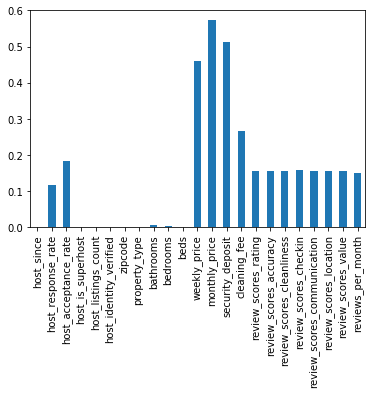

In [170]:
# Data assessment - visually assessing the proportion of missing values in rest of the columns
missing2_dfs = dfs.isnull().mean()
missing2_cols_nan = missing2_dfs[missing2_dfs>0]
missing2_cols_nan.plot.bar()
# Two issues to track in each column - 1. data type 2. Missing values
#Need to worry about fully filled cols that are objects as well - need to convert to int or float for ML package
print('number of columns with Nan values after merging and dropping:',len(missing2_cols_nan))
# Output - Some of the price-like columns need to be imputed by its mean values

In [171]:
# Data assessment - assessing the object type columns in rest of the columns
cat_cols_lst = dfs.select_dtypes(include=['object']).columns
len(cat_cols_lst)
cat_cols_lst
#dfs.info()

Index(['date', 'price_x', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_verifications',
       'host_identity_verified', 'zipcode', 'property_type', 'room_type',
       'bed_type', 'amenities', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [172]:
# Data Cleaning - Renaming price_x as price and converting to float
dfs['price'] = dfs['price_x'].astype(str)
dfs['price'] = dfs['price'].str.replace("[$, ]", "").astype("float")
dfs = dfs.drop(columns = ['price_x'])

In [173]:
# data cleaning - Changing the price and date column
dfs['date'] = pd.to_datetime(dfs['date'])
dfs['month'] = dfs.date.dt.month
dfs['year'] = dfs.date.dt.year
dfs['day'] = dfs.date.dt.day
dfs = dfs.drop(columns = ['date'])
# Now there are 46 columns with many object type cols and missing rows for cols of both float and object types

In [174]:
# Data cleaning - Function to convert price columns masquerading as object type columns & removing the $, symbols
def str_to_num(df,column):
    """Description: This function is for the price columns. They are object types.
    Covert datatype to string and removes the $ and quotes. 
    Arguments:  column: price;df: dataframe
    Returns: 
    return the price columns back as float"""
    df[column] = pd.to_numeric(df[column].apply(lambda x : str(x).replace('$','').replace(",",'')),errors='coerce')
    return df

columns1 = ['price','monthly_price','weekly_price','security_deposit','cleaning_fee', 'extra_people']

for col in columns1:
    dfs=str_to_num(dfs,col)
    

In [175]:
# Data cleaning
# Object type 'host_since' is converted to float64; Looks like date type in csv,so only retaining the year; impute with mean
dfs['host_since'] = pd.to_datetime(dfs['host_since'])
dfs['host_since_year'] = dfs.host_since.dt.year
dfs['host_since_year'].fillna(dfs['host_since_year'].mean(), inplace = True)
dfs = dfs.drop(columns = ['host_since'])

In [176]:
#data cleaning
def obj_to_num_fillmean(df,column):
    """Description: This function is for a few object columns.
    Covert datatype to string to float. Fill the missing values with the mean of the column
    Arguments:  columns;df: dataframe
    Returns:  return the columns back as float and filled in mean values"""
    df[column] = df[column].astype(str)
    df[column] = df[column].str.replace("%", "").astype("float")
    df[column].fillna(df[column].mean(), inplace = True)
    return df

columns = ['host_response_rate','host_acceptance_rate']

for col in columns:
    dfs=obj_to_num_fillmean(dfs,col)

In [177]:
# Data Cleaning - True or false type columns are converted to numerical 1 or 0
dfs['host_identity_verified']=dfs['host_identity_verified'].fillna(0)
def obj_to_tfcat_fillmean(df,column):
    """Description: This function is to map 't' & 'f' to 1 & 0 respectively. They are object types.
       Arguments:  column: price;df: dataframe
    Returns: 
    return the price columns back as float"""
    df[column]=np.where(df[column]=='t',1,0)
    return df

columns = ['host_is_superhost','instant_bookable','require_guest_profile_picture',
           'require_guest_phone_verification', 'host_identity_verified' ]

for col in columns:
    dfs=obj_to_tfcat_fillmean(dfs,col)

In [178]:
# Data cleaning - Existing nuerical columns with missing values are imputed by their mean
def num_fillmean(df,column):
    """Description: This function is for a few float/int columns.
    Covert datatype to string to float. Fill the missing values with the mean of the column
    Arguments:  columns;df: dataframe
    Returns:  return the columns with filled in mean values"""
    df[column].fillna(df[column].mean(), inplace = True)
    return df

columns = ['host_listings_count','weekly_price','monthly_price','security_deposit','cleaning_fee','review_scores_rating',
          'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
           'review_scores_location','review_scores_value']

for col in columns:
    dfs=num_fillmean(dfs,col)

In [179]:
# Data cleaning - Existing categorical object type columns with missing values are imputed by their mean
def cat_fillmode(df,column):
    """Description: This function is for a few object columns.
    Fill the missing values with the mode of the column
    Arguments:  columns;df: dataframe
    Returns:  return the columns with filled in mode values"""
    df[column].fillna(df[column].mode()[0], inplace = True)
    return df

columns = ['bathrooms','bedrooms','beds','property_type']

for col in columns:
    dfs=cat_fillmode(dfs,col)

In [180]:
#Data cleaning in 'zipcode' column
#zipcode with missing values -  has Nan - replace by mode; problematic value '99\n98122'
dfs['zipcode']= dfs['zipcode'].fillna(dfs['zipcode'].mode()[0])
dfs['zipcode'] = dfs['zipcode'].astype(str)
dfs['zipcode'] = dfs['zipcode'].str.replace("99\n98122", "98122").astype("int")

In [ ]:
#'host_verificiations' and 'amenties' have rows filled wiht a list

In [181]:
dfs.shape

(934542, 50)

In [182]:
dfs.columns

Index(['listing_id', 'host_id', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_verifications',
       'host_identity_verified', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'price', '

In [183]:
# Data preparing for ML model 
#Dropping column of list with quotes on elements - DROP
dfs = dfs.drop(columns = ['host_verifications', 'amenities'])

In [184]:
# Data preparation - important categorical object columns cannot be droped. pf.get_dummies is used to create 
# dummy categorical columns of each type in each object type column
cat_columns = list(dfs.select_dtypes(include=['object']).columns)
    
for col in  cat_columns:
    dfs = pd.concat([dfs.drop(col, axis=1), pd.get_dummies(dfs[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=True)], axis=1)
#drop listing_id and year columns as they are not required for the ML part
dfs = dfs.drop(columns = ['listing_id', 'year'])

In [185]:
#Data preparation for the ML model  - Key feature (price) and all other features as X; 
#Split data sets to 70% for training the ML model; 30 % for testing the ML model
X = dfs.drop(columns = 'price')
y = dfs[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [186]:
# Data modeling - Optimized gradient boosting framework - XGBoost regressor (for question 3)
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)

#predictions and scoring for the XGB model
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))
# Output - model assessments by scoring the model from training and testing data sets

[14:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 578.160, test: 587.052
R^2 train: 0.948, test: 0.946


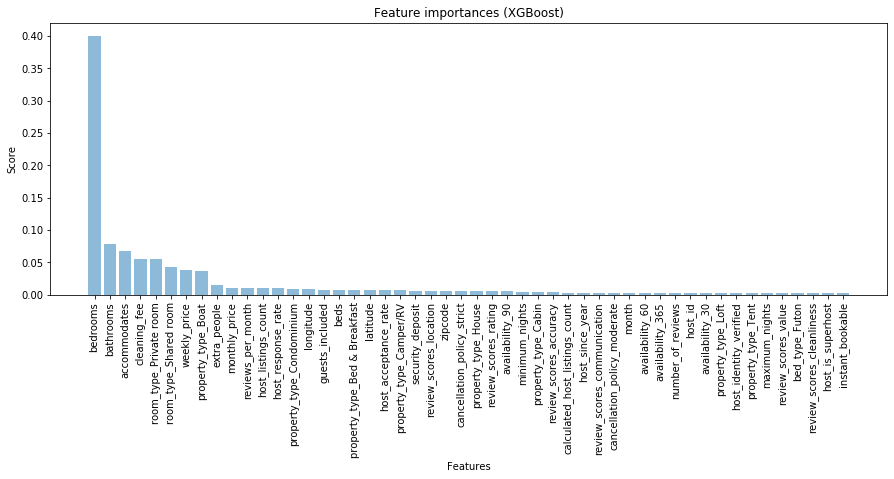

In [188]:
#Model validation and visualization  - get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances for top 50 features
features = xgb_feature_importances['name'][:50]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:50]
 
plt.figure(figsize=(15,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)')

plt.savefig('feature_importances_XGB_seattle50.png')
 
plt.show()

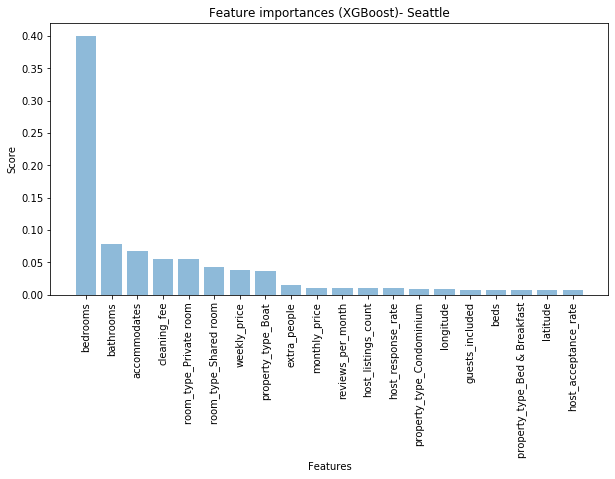

In [190]:
#Model validation and visualization  - get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances for top 20 features
features = xgb_feature_importances['name'][:20]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:20]
 
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)- Seattle')

plt.savefig('feature_importances_XGB_seattle20.png')
 
plt.show()